In [46]:
# See https://blog.keras.io/building-autoencoders-in-keras.html

In [47]:
%reset -f

In [48]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import regularizers

import numpy as np

import pickle as pk

### Load Data

In [49]:
data = np.load('mnist.npz')
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

In [50]:
x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Build a Sparse (Regularized) AutoEncoder

In [51]:
enc_dim = 32

sz = x_train.shape[1]

theInput = Input(shape=(sz,))
network = Dense(enc_dim, activation='relu', activity_regularizer=regularizers.l1(10e-8))(theInput)
network = Dense(sz, activation='sigmoid')(network)

autoencoder = Model(theInput, network)

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# cbEarlyStop = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=3, verbose=0, mode='auto')
# hist = autoencoder.fit(x_train, x_train, epochs=500, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[cbEarlyStop])

hist = autoencoder.fit(x_train, x_train, epochs=200, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

In [52]:
sparseAutoencoder = pk.dump((autoencoder, hist), open('sparseAutoencoder.pk', 'wb'))

autoencoder, hist = pk.load(open('sparseAutoencoder.pk', 'rb'))

In [53]:
encoderInput = Input(shape=(sz,))
encoderLayers = autoencoder.layers[1](encoderInput)
encoder = Model(encoderInput, encoderLayers)

In [54]:
decoderInput = Input(shape=(enc_dim,))
decoderOutput = autoencoder.layers[-1](decoderInput)
decoder = Model(decoderInput, decoderOutput)

In [55]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

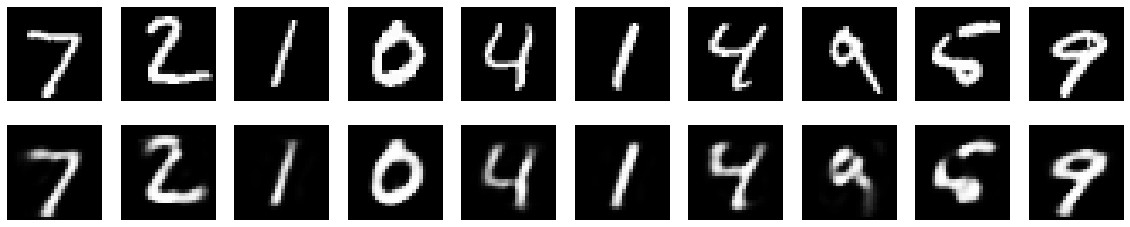

In [56]:
n = 10  # how many digits we will display

sz = data['x_train'].shape[1]

plt.figure(figsize=(20, 4))

for i in range(n):
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(sz, sz))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(sz, sz))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

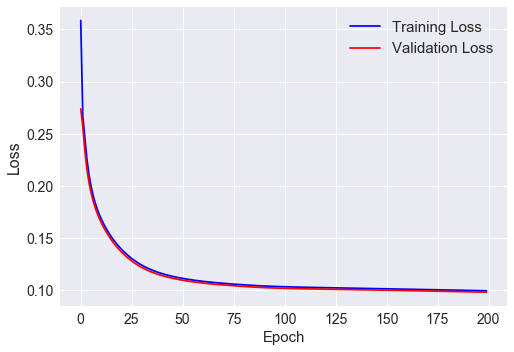

In [57]:
loss = hist.history.get('loss')
val_loss = hist.history.get('val_loss')

plt.plot(loss, 'b')
plt.plot(val_loss, 'r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=15)
plt.show()

In [58]:
hist.history['val_loss'][-1]

0.09826246412992477